In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F     
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
    

In [ ]:
class CRNN(nn.Module):
    def __init__(self, input_channels, num_classes, img_height, img_width):
        super(CRNN, self).__init__()

        # Deeper CNN for spatial features, follows VGG arch
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=2, padding=0)
        
        # Batch normalization layers
        self.bn4 = nn.BatchNorm2d(256)
        self.bn6 = nn.BatchNorm2d(512)
        
        # Pooling layers
        self.pool = nn.MaxPool2d(2, 2)
        self.pool_h = nn.MaxPool2d(kernel_size=(2, 1))  

        # Calculate output dimensions after CNN layers
        cnn_output_height = img_height // 16 - 1 
        cnn_output_width = img_width // 4 - 1
        rnn_input_size = 512 * cnn_output_height

        # Two-layer bidirectional LSTM like in the reference
        self.bi_lstm1 = nn.LSTM(input_size=rnn_input_size, hidden_size=256, bidirectional=True, batch_first=False)
        self.bi_lstm2 = nn.LSTM(input_size=256*2, hidden_size=256, bidirectional=True, batch_first=False)

        # Final classification layer (Transcription layer)
        self.fc = nn.Linear(256 * 2, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        # conv3 and conv4 do not have pooling
        x = F.relu(self.conv3(x))  
        x = F.relu(self.bn4(self.conv4(x)))  
        x = self.pool_h(x) 
        # conv5 and conv6 with batch normalization and pooling with respect to height at the end
        x = F.relu(self.conv5(x))  
        x = F.relu(self.bn6(self.conv6(x)))  
        x = self.pool_h(x)  
        x = F.relu(self.conv7(x))  

        """
        According to the paper
        from left to right, a vector of feature sequence is generated from the feature maps. 
        This means the ith feature vector is the concatenation of the ith column of all maps
        """
        b, c, h, w = x.size()
        # (Batch size, channels*height, width)
        x = x.view(b, c*h, w)
        # (sequence length = width, batch = b, features = channels*height)
        x = x.permute(2, 0, 1)  

        # RNN layer
        x, _ = self.bi_lstm1(x)
        x, _ = self.bi_lstm2(x)

        x = self.fc(x)
        return x

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [5]:
vocab = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
char_to_idx = {c:i+1 for i, c in enumerate(vocab)} 
idx_to_char = {i+1:c for i, c in enumerate(vocab)}


In [6]:
input_channels = 3
# vocab size (no. of characters) + blank
num_classes = len(vocab) + 1 
img_height = 200
img_width = 80

In [7]:
model = CRNN(input_channels=input_channels, num_classes=num_classes, img_height=img_height, img_width=img_width).to(device)

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transforms = None, char_to_idx = None):
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir 
        self.transforms = transforms
        self.char_to_idx = char_to_idx


    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path)
        label = self.labels_df.iloc[idx, 1]
        y_label = [self.char_to_idx[c] for c in label]
        # print(y_label)
        if self.transforms:
            image = self.transforms(image)

        return image, torch.tensor(y_label)

In [9]:
transform = transforms.Compose([
    transforms.Resize((200, 80)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [10]:
train_dataset_easy = CustomImageDataset(
    csv_file = 'captcha_images/train/labels_easy.csv',
    img_dir = 'captcha_images/train/easy',
    transforms = transform,
    char_to_idx = char_to_idx 
)

train_dataset_hard = CustomImageDataset(
    csv_file = 'captcha_images/train/labels_hard.csv',
    img_dir = 'captcha_images/train/hard',
    transforms = transform,
    char_to_idx = char_to_idx
)

train_dataset = ConcatDataset([train_dataset_easy, train_dataset_hard])


test_dataset_easy = CustomImageDataset(
    csv_file = 'captcha_images/test/labels_easy.csv',
    img_dir = 'captcha_images/test/easy',
    transforms = transform,
    char_to_idx = char_to_idx
)

test_dataset_hard = CustomImageDataset(
    csv_file = 'captcha_images/test/labels_hard.csv',
    img_dir = 'captcha_images/test/hard',
    transforms = transform,
    char_to_idx = char_to_idx
)

test_dataset = ConcatDataset([test_dataset_easy, test_dataset_hard])


In [11]:
def ctc_collate_fn(batch):
    # [(image, tensor label), (image, tensor label)] -> (image1, image2), (tensor label1, tensor label2), (len(target label1), len(target label2))
    images, labels = zip(*batch)
    images = torch.stack(images)

    targets = torch.cat(labels)

    target_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long)

    return images, targets, target_lengths

In [ ]:

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=ctc_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=ctc_collate_fn)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [14]:
# Earlier I used CrossEntropyLoss, but that cant handle variable target lengths. CTC loss was also mentioned to be used in the paper.
criterion = nn.CTCLoss(blank=0, zero_infinity=True)

In [15]:
num_epochs = 15

#### **Trained on Kaggle using P100 GPU for 30 epochs with batch_size 32**

In [ ]:

# for epoch in range(num_epochs):
#     model.train()
#     epoch_loss = 0.0
#     for batch_idx, (data, targets, target_lengths) in enumerate(train_dataloader):
#         data = data.to(device = device)
#         targets = targets.to(device = device)
#         target_lengths = target_lengths.to(device = device)

#         # Forward pass
#         scores = model(data)
#         scores = scores.log_softmax(2)

#         seq_len, batch_size, _ = scores.size()
#         input_lengths = torch.full(size=(batch_size,), fill_value=seq_len, dtype=torch.long).to(device)
        
#         loss = criterion(scores, targets, input_lengths, target_lengths)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         epoch_loss += loss.item()
    
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_dataloader):.4f}')


In [ ]:
# # Save the trained model
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'vocab': vocab,
#     'char_to_idx': char_to_idx,
#     'idx_to_char': idx_to_char,
#     'num_classes': num_classes,
#     'img_height': img_height,
#     'img_width': img_width,
#     'input_channels': input_channels
# }, 'deep_crnn_model.pth')


- Number of epochs as 10 - 1% accuracy
- Number of epochs as 100 - 100% accuracy
- Right now model is just memorizing, need to add more samples.

- then i reduced from 6m to 500k parameters and model works fine now.

# **Test with the wordlist captcha dataset (dataset used for training CNN in Task1)**

In [17]:

train_dataset_easy = CustomImageDataset(
    csv_file = 'wordlist_captcha_images/train/labels_easy.csv',
    img_dir = 'wordlist_captcha_images/train/easy',
    transforms = transform,
    char_to_idx = char_to_idx 
)

train_dataset_hard = CustomImageDataset(
    csv_file = 'wordlist_captcha_images/train/labels_hard.csv',
    img_dir = 'wordlist_captcha_images/train/hard',
    transforms = transform,
    char_to_idx = char_to_idx
)

train_dataset = ConcatDataset([train_dataset_easy, train_dataset_hard])


test_dataset_easy = CustomImageDataset(
    csv_file = 'wordlist_captcha_images/test/labels_easy.csv',
    img_dir = 'wordlist_captcha_images/test/easy',
    transforms = transform,
    char_to_idx = char_to_idx
)

test_dataset_hard = CustomImageDataset(
    csv_file = 'wordlist_captcha_images/test/labels_hard.csv',
    img_dir = 'wordlist_captcha_images/test/hard',
    transforms = transform,
    char_to_idx = char_to_idx
)

test_dataset = ConcatDataset([test_dataset_easy, test_dataset_hard])


In [ ]:

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=ctc_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=ctc_collate_fn)

In [19]:
def ctc_collate_fn(batch):
    # [(image, tensor label), (image, tensor label)] -> (image1, image2), (tensor label1, tensor label2), (len(tensor label1), len(tensor label2))
    images, labels = zip(*batch)
    images = torch.stack(images)

    targets = torch.cat(labels)

    target_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long)

    return images, targets, target_lengths

In [ ]:
def load_model(model_path='DeepCRNN_model.pth'):
    checkpoint = torch.load(model_path, map_location=device)

    loaded_model = CRNN(
        input_channels=checkpoint['input_channels'],
        num_classes=checkpoint['num_classes'],
        img_height=checkpoint['img_height'],
        img_width=checkpoint['img_width']
    ).to(device)
    
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    
    vocab = checkpoint['vocab']
    char_to_idx = checkpoint['char_to_idx']
    idx_to_char = checkpoint['idx_to_char']
    
    print(f"Model loaded from {model_path}")
    return loaded_model, vocab, char_to_idx, idx_to_char

In [21]:
model, vocab, char_to_idx, idx_to_char = load_model()

Model loaded from DeepCRNN_model.pth


In [ ]:
def ctc_decode(preds, idx_to_char):
    preds = preds.cpu().numpy()
    seq_len, batch_size = preds.shape
    decoded = []

    for b in range(batch_size):
        seq = preds[:, b]
        word = []
        prev = None
        for idx in seq:
            # remove blanks which is 0 in the list
            if idx != prev and idx != 0:  
                word.append(idx_to_char[idx])
            prev = idx
        decoded.append("".join(word))
    return decoded


In [161]:
def check_crnn_accuracy(loader, model, idx_to_char):
    model.eval()
    num_correct = 0
    num_samples = 0

    with torch.no_grad():
        for images, targets, target_lengths in loader:
            images = images.to(device)
            # forward pass
            scores = model(images)  
            preds = scores.argmax(2)  
            decoded_words = ctc_decode(preds, idx_to_char)

            # reconstruct true words from targets
            targets = targets.cpu().numpy()
            ptr = 0
            true_words = []
            for length in target_lengths:
                word_indices = targets[ptr:ptr+length]
                word = "".join([idx_to_char[idx] for idx in word_indices])
                true_words.append(word)
                ptr += length

            # compare
            for pred_word, true_word in zip(decoded_words, true_words):
                if pred_word == true_word:
                    num_correct += 1
                num_samples += 1

    acc = num_correct / num_samples
    print(f'Accuracy: {acc*100:.2f}% ({num_correct}/{num_samples})')
    return acc

check_crnn_accuracy(train_dataloader, model, idx_to_char)
check_crnn_accuracy(test_dataloader, model, idx_to_char)


Accuracy: 95.20% (8187/8600)
Accuracy: 95.54% (2465/2580)
Accuracy: 95.54% (2465/2580)


0.9554263565891473

## **Testing the DeepCRNN model on images and visualizing the output**

In [ ]:
def predict_image(model, img_path, transform, idx_to_char, device):
    model.eval()
    
    image = Image.open(img_path).convert('RGB')
    # we need to add batch dimension
    image = transform(image).unsqueeze(0)  
    image = image.to(device)
    
    with torch.no_grad():
        scores = model(image)
        preds = scores.argmax(2)  
        
        decoded = ctc_decode(preds, idx_to_char)
        return decoded[0]  

In [37]:
import random
import matplotlib.pyplot as plt

# Load 10 random samples from easy and hard categories
# easy
with open('wordlist_captcha_images/test/labels_easy.csv', 'r') as f:
    easy_samples = random.sample(f.readlines(), 10)
    easy_samples = [(line.split(',')[0], line.split(',')[1].strip()) for line in easy_samples]

# hard
with open('wordlist_captcha_images/test/labels_hard.csv', 'r') as f:
    hard_samples = random.sample(f.readlines(), 10)
    hard_samples = [(line.split(',')[0], line.split(',')[1].strip()) for line in hard_samples]

# Run the model and save the results
easy_results = []
hard_results = []

for img_name, true_label in easy_samples:
    img_path = f'wordlist_captcha_images/test/easy/{img_name}'
    pred_label = predict_image(model, img_path, transform, idx_to_char, device)
    easy_results.append((img_name, true_label, pred_label))

for img_name, true_label in hard_samples:
    img_path = f'wordlist_captcha_images/test/hard/{img_name}'
    pred_label = predict_image(model, img_path, transform, idx_to_char, device)
    hard_results.append((img_name, true_label, pred_label))

# Calculate accuracy
easy_correct = sum(1 for _, true_label, pred_label in easy_results if true_label == pred_label)
hard_correct = sum(1 for _, true_label, pred_label in hard_results if true_label == pred_label)

easy_accuracy = easy_correct / len(easy_results) * 100
hard_accuracy = hard_correct / len(hard_results) * 100

In [38]:
print(f"\nAccuracy Results:")
print(f"Easy samples: {easy_correct}/{len(easy_results)} = {easy_accuracy:.1f}%")
print(f"Hard samples: {hard_correct}/{len(hard_results)} = {hard_accuracy:.1f}%")
print(f"Overall: {easy_correct + hard_correct}/{len(easy_results) + len(hard_results)} = {(easy_correct + hard_correct) / (len(easy_results) + len(hard_results)) * 100:.1f}%")


Accuracy Results:
Easy samples: 9/10 = 90.0%
Hard samples: 9/10 = 90.0%
Overall: 18/20 = 90.0%


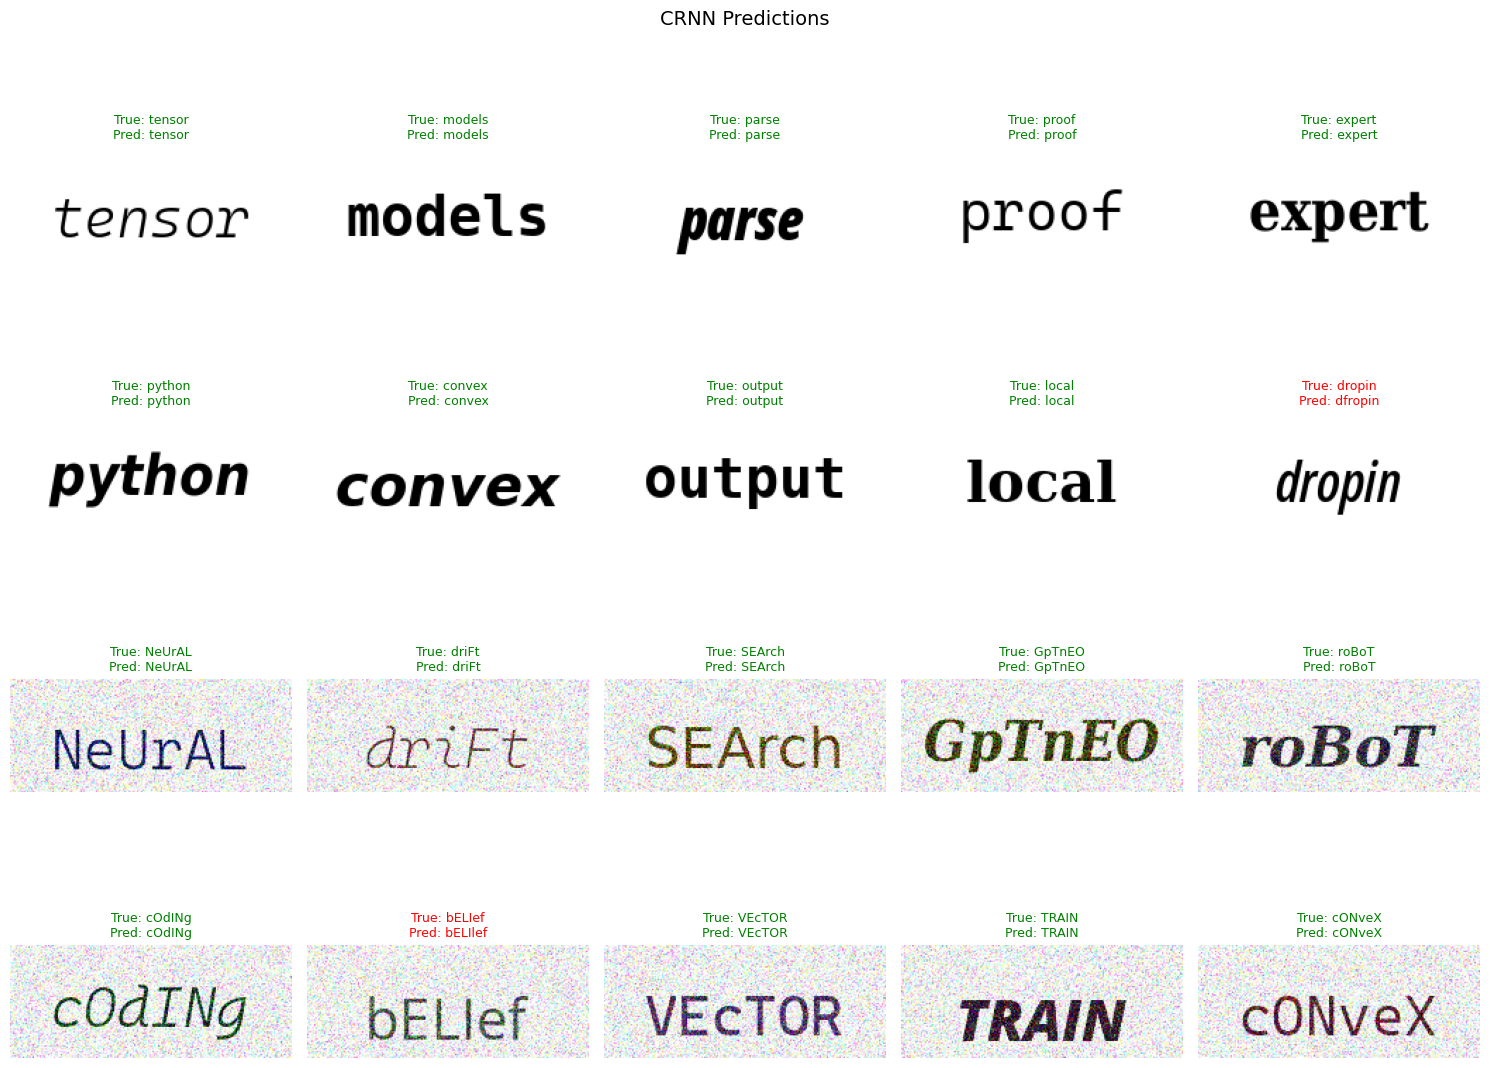

In [41]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle("CRNN Predictions", fontsize=14)

results = easy_results + hard_results

for i in range(len(results)):
    img_name, true_lbl, pred_lbl = results[i]
    row = i // 5
    col = i % 5
    
    found = False
    for r in easy_results:
        if r[0] == img_name:
            img_path = "wordlist_captcha_images/test/easy/" + img_name
            found = True
            break
    if not found:
        img_path = "wordlist_captcha_images/test/hard/" + img_name
    
    img = plt.imread(img_path)
    axs[row, col].imshow(img)
    axs[row, col].axis("off")
    
    if true_lbl == pred_lbl:
        color = "green"
    else:
        color = "red"
    axs[row, col].set_title("True: " + str(true_lbl) + "\nPred: " + str(pred_lbl), fontsize=9, color=color)

plt.tight_layout()
plt.show()

# calculate accuracy
easy_correct = 0
for r in easy_results:
    if r[1] == r[2]:
        easy_correct += 1
hard_correct = 0
for r in hard_results:
    if r[1] == r[2]:
        hard_correct += 1

easy_acc = easy_correct / len(easy_results) * 100
hard_acc = hard_correct / len(hard_results) * 100
overall_acc = (easy_correct + hard_correct) / (len(easy_results) + len(hard_results)) * 100